In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [3]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [4]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

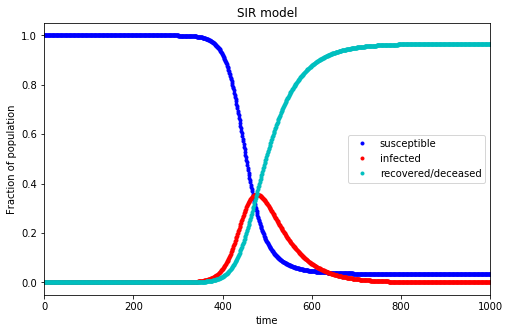

In [5]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

In [22]:
TodaysData_Country = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')

TodaysData_Country.head()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String
0,Afghanistan,1/22/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/22
1,Afghanistan,1/23/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/23
2,Afghanistan,1/24/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/24
3,Afghanistan,1/25/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/25
4,Afghanistan,1/26/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/26


In [23]:
TodaysData_Country = TodaysData_Country[TodaysData_Country['Province_State'].isnull()]
TodaysData_Country = TodaysData_Country.query('Country_Region=="US"' )
ColumnToClean = ['Confirmed', 'Deaths', 'Recovered', 'Active']
# filling missing values 
TodaysData_Country[['Country_Region']] = TodaysData_Country[['Country_Region']].fillna('')
TodaysData_Country[ColumnToClean] = TodaysData_Country[ColumnToClean].fillna(0)
TodaysData_Country = TodaysData_Country.drop([ 'Country_Region','Last_Update','Active','Delta_Confirmed','Delta_Recovered','Incident_Rate','People_Tested','People_Hospitalized','Province_State','FIPS','UID','iso3'], axis=1) 
#TodaysData_Country['Report_Date_String'] = pd.to_datetime(TodaysData_Country['Report_Date_String'],"%Y-%m-%d")
TodaysData_Country.head()


,Confirmed,Deaths,Recovered,Report_Date_String
25056,1,0,0.0,2020/01/22
25057,1,0,0.0,2020/01/23
25058,2,0,0.0,2020/01/24
25059,2,0,0.0,2020/01/25
25060,5,0,0.0,2020/01/26


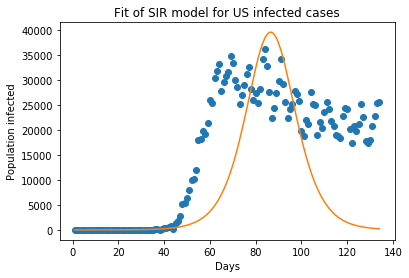

Optimal parameters: beta = 9.074385032247383  and gamma =  8.934291586432785


In [25]:
population = float(331002651) # US population
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = TodaysData_Country.Confirmed.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for US infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])